# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility

In [2]:
from tqdm import tqdm

In [3]:
def softmax(x, temp):
    exps = np.exp((x - np.max(x)) / temp)
    return exps / np.sum(exps)

In [4]:
class SARSA:
  def __init__(self, env, alpha, gamma, temp):
      self.env = env
      self.alpha = alpha
      self.gamma = gamma
      self.temp = temp
      self.Q = np.zeros((env.observation_space.n, env.action_space.n))


  def select_action(self, s, greedy=False):  
      # write your solution here
      if greedy:
          return np.argmax(self.Q[s])
      else:
          action_probs = softmax(self.Q[s], self.temp)
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):
      target = r + self.gamma * self.Q[s_prime, a_prime] * (not done)
      td_error = target - self.Q[s, a]
      self.Q[s, a] += self.alpha * td_error


class ExpectedSARSA:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
      self.env = env
      self.alpha = alpha
      self.gamma = gamma
      self.temp = temp
      self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  def select_action(self, s, greedy=False):
      # write your solution here
      if greedy:
          return np.argmax(self.Q[s])
      else:
          action_probs = softmax(self.Q[s], self.temp)
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):

      # write your solution here
      action_probs = softmax(self.Q[s_prime], self.temp)
      expected_q = np.sum(action_probs * self.Q[s_prime])
      target = r + self.gamma * expected_q * (not done)
      td_error = target - self.Q[s, a]
      self.Q[s, a] += self.alpha * td_error

# bonus question, optional
class Hybrid_SARSA_Q:
  def __init__(self, env, alpha, gamma, temp, beta):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp  # Temperature for softmax
    self.beta = beta  # Mixing factor
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-table
  
  def select_action(self, s, greedy=False):
    # write your solution here
      if greedy:
          return np.argmax(self.Q[s])  # Choose the best action for evaluation
      else:
          action_probs = softmax(self.Q[s], self.temp)  # Use softmax for exploration
          return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
      # Calculate the target with a mixture of max Q and expected Q
      max_q_prime = np.max(self.Q[s_prime])
      action_probs_prime = softmax(self.Q[s_prime], self.temp)
      expected_q_prime = np.sum(action_probs_prime * self.Q[s_prime])
      target = r + self.gamma * ((1 - self.beta) * max_q_prime + self.beta * expected_q_prime) * (not done)

      # TD error
      td_error = target - self.Q[s, a]

      # Q-table update
      self.Q[s, a] += self.alpha * td_error

# Write your experiment code below


In [5]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
env = StepAPICompatibility(env)#, new_step_api=True)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


## Run Experiments


In [6]:
# Parameters
alpha_values = [0.1,0.2,0.5]
temp_values = [0.005,0.01,0.02]
trials = 10
segments = 500
episodes_per_segment = 10  # Training episodes
testing_episode = 1  # Testing episodes per segment

# Initialize the environment
env = gym.make(env_name)

In [7]:
# function that runs each episode
def run_experiment(agent_class, env, alpha, temp, segments=500, episodes_per_segment=10, trials=10):
    """
    Run complete experiment for given agent and parameters.
    
    This function runs multiple trials of the learning process, each consisting of
    multiple segments, where each segment contains training episodes followed by
    a testing episode.
    
    Args:
        agent_class: Class of the RL agent (SARSA or Expected SARSA)
        env: OpenAI Gym environment
        alpha (float): Learning rate
        temp (float): Temperature parameter
        segments (int): Number of segments to run
        episodes_per_segment (int): Number of training episodes per segment
        trials (int): Number of independent trials to run
    
    Returns:
        tuple: (training_results, testing_results) containing performance data
    """
    training_results = np.zeros((trials, segments))
    testing_results = np.zeros((trials, segments))
    
    for trial in tqdm(range(trials)):
        # Initialize new agent for each trial
        agent = agent_class(env, alpha, gamma=0.99, temp=temp)
        
        for segment in range(segments):
            segment_rewards = []
            
            # Training episodes
            for _ in range(episodes_per_segment):
                state, _ = env.reset()
                done = False
                total_reward = 0
                
                while not done:
                    # Select and execute action
                    action = agent.select_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated
                    
                    # Select next action and update agent
                    next_action = agent.select_action(next_state)
                    agent.update(state, action, reward, next_state, next_action, done)
                    
                    state = next_state
                    action = next_action
                    total_reward += reward
                
                segment_rewards.append(total_reward)
            
            # Store average training performance for this segment
            training_results[trial, segment] = np.mean(segment_rewards)
            
            # Testing episode (greedy policy)
            state, _ = env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = agent.select_action(state, greedy=True)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                total_reward += reward
            
            testing_results[trial, segment] = total_reward
    
    return training_results, testing_results


In [8]:
# Storage for results
sarsa_results = {
    'training': np.zeros((len(alpha_values), len(temp_values), 10, 500)),
    'testing': np.zeros((len(alpha_values), len(temp_values), 10, 500))
}

expected_sarsa_results = {
    'training': np.zeros((len(alpha_values), len(temp_values), 10, 500)),
    'testing': np.zeros((len(alpha_values), len(temp_values), 10, 500))
}

# Run experiments for each hyperparameter setting
for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        print(f"\nRunning SARSA with alpha={alpha}, temp={temp}")
        train_results, test_results = run_experiment(SARSA, env, alpha, temp)
        sarsa_results['training'][i, j] = train_results
        sarsa_results['testing'][i, j] = test_results
        
        print(f"\nRunning Expected SARSA with alpha={alpha}, temp={temp}")
        train_results, test_results = run_experiment(ExpectedSARSA, env, alpha, temp)
        expected_sarsa_results['training'][i, j] = train_results
        expected_sarsa_results['testing'][i, j] = test_results



Running SARSA with alpha=0.1, temp=0.005


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:35<00:00,  3.50s/it]



Running Expected SARSA with alpha=0.1, temp=0.005


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]



Running SARSA with alpha=0.1, temp=0.01


100%|██████████| 10/10 [00:40<00:00,  4.02s/it]



Running Expected SARSA with alpha=0.1, temp=0.01


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]



Running SARSA with alpha=0.1, temp=0.02


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]



Running Expected SARSA with alpha=0.1, temp=0.02


100%|██████████| 10/10 [00:37<00:00,  3.79s/it]



Running SARSA with alpha=0.2, temp=0.005


100%|██████████| 10/10 [00:38<00:00,  3.85s/it]



Running Expected SARSA with alpha=0.2, temp=0.005


100%|██████████| 10/10 [00:47<00:00,  4.74s/it]



Running SARSA with alpha=0.2, temp=0.01


100%|██████████| 10/10 [00:43<00:00,  4.31s/it]



Running Expected SARSA with alpha=0.2, temp=0.01


100%|██████████| 10/10 [00:55<00:00,  5.58s/it]



Running SARSA with alpha=0.2, temp=0.02


100%|██████████| 10/10 [00:44<00:00,  4.46s/it]



Running Expected SARSA with alpha=0.2, temp=0.02


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]



Running SARSA with alpha=0.5, temp=0.005


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]



Running Expected SARSA with alpha=0.5, temp=0.005


100%|██████████| 10/10 [01:25<00:00,  8.51s/it]



Running SARSA with alpha=0.5, temp=0.01


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]



Running Expected SARSA with alpha=0.5, temp=0.01


100%|██████████| 10/10 [01:22<00:00,  8.22s/it]



Running SARSA with alpha=0.5, temp=0.02


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]



Running Expected SARSA with alpha=0.5, temp=0.02


100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


# Graph 1


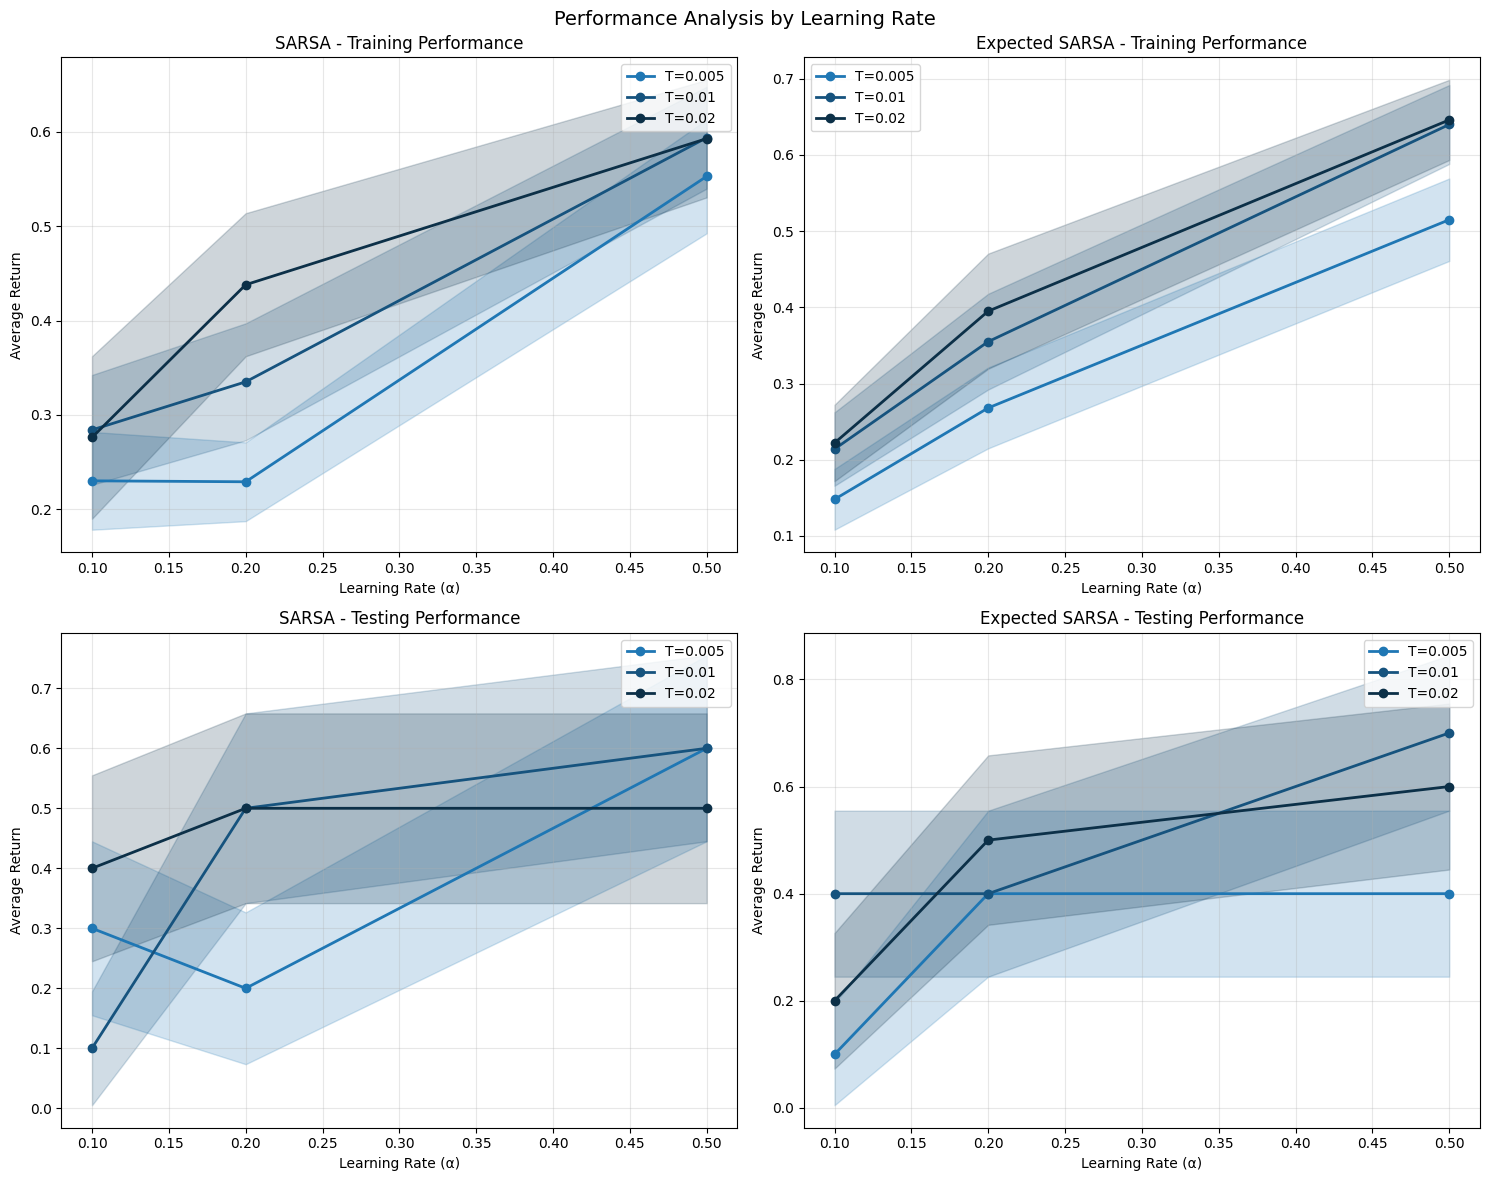

In [12]:
def plot_learning_rate_analysis(sarsa_results, expected_sarsa_results, alpha_values, temp_values, modes = ['training', 'testing']):
    """
    Create plots showing how learning rate affects performance for different temperatures.

    Args:
        sarsa_results: Dictionary containing SARSA algorithm results
        expected_sarsa_results: Dictionary containing Expected SARSA results
        alpha_values: List of learning rates used in experiments
        temp_values: List of temperature values used in experiments
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Performance Analysis by Learning Rate', fontsize=14)
    
    # Create base colors for different temperatures
    # Using blue color with different shades for different temperatures
    base_color = np.array(plt.matplotlib.colors.to_rgb('#1f77b4'))
    colors = [base_color * (1 - (i * 0.3)) for i in range(len(temp_values))]
    
    algorithms = [('SARSA', sarsa_results), ('Expected SARSA', expected_sarsa_results)]
    
    for alg_idx, (alg_name, results) in enumerate(algorithms):
        for mode_idx, mode in enumerate(modes):
            ax = axes[mode_idx, alg_idx]
            
            for j, temp in enumerate(temp_values):
                # Calculate performance metrics
                if mode == 'training':
                    # Average over last 10 episodes and all trials
                    performance = np.mean(results[mode][:, j, :, -10:], axis=(1, 2))
                    std_err = np.std(results[mode][:, j, :, -10:], axis=(1, 2)) / np.sqrt(10)
                else:
                    # Average over trials for final episode
                    performance = np.mean(results[mode][:, j, :, -1], axis=1)
                    std_err = np.std(results[mode][:, j, :, -1], axis=1) / np.sqrt(10)
                
                # Plot mean performance line
                ax.plot(alpha_values, performance, 
                       label=f'T={temp}',
                       color=colors[j],
                       linewidth=2,
                       marker='o')
                
                # Add error bands to show variance
                ax.fill_between(alpha_values,
                              performance - std_err,
                              performance + std_err,
                              color=colors[j],
                              alpha=0.2)
            
            # Customize plot appearance
            ax.set_xlabel('Learning Rate (α)')
            ax.set_ylabel('Average Return')
            ax.set_title(f'{alg_name} - {mode.capitalize()} Performance')
            ax.grid(True, alpha=0.3)
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Generate the learning rate analysis plots
plot_learning_rate_analysis(sarsa_results, expected_sarsa_results, alpha_values, temp_values)

# Graph 2


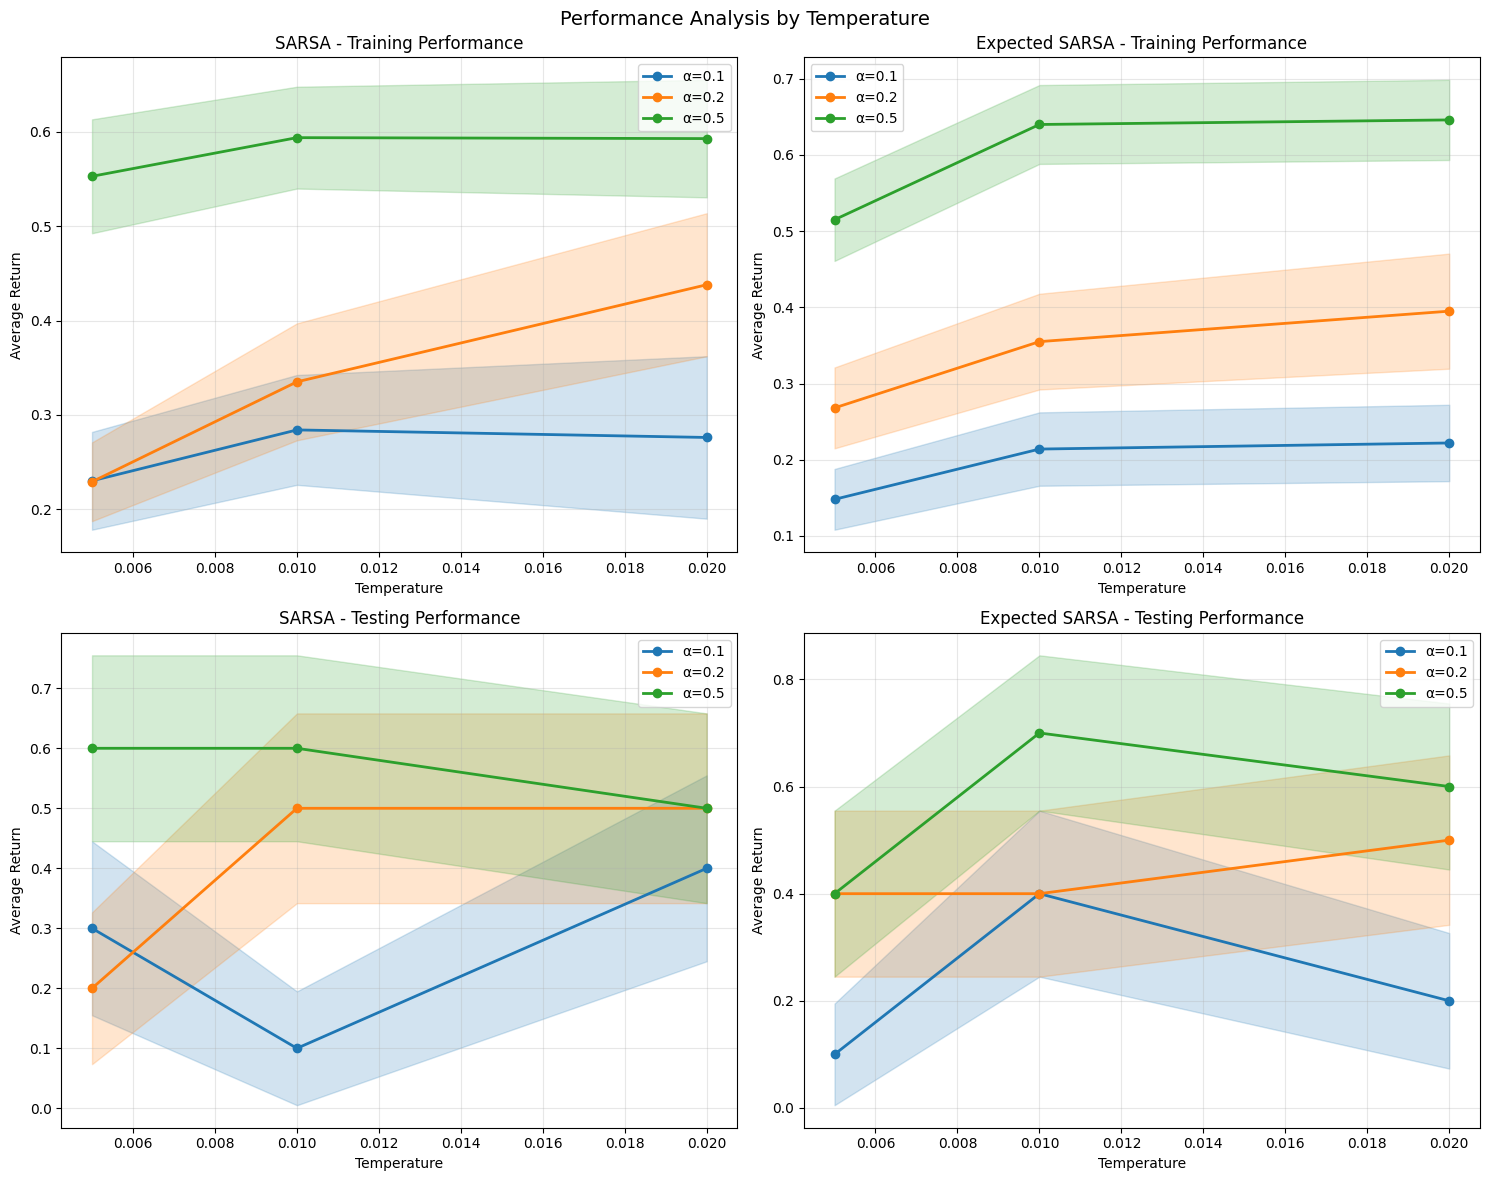

In [14]:
def plot_temperature_analysis(sarsa_results, expected_sarsa_results, alpha_values, temp_values):
    """
    Create plots showing how temperature affects performance for different learning rates.
    Displays both training and testing performance for SARSA and Expected SARSA.
    
    Args:
        sarsa_results: Results dictionary for SARSA
        expected_sarsa_results: Results dictionary for Expected SARSA
        alpha_values: List of learning rates used
        temp_values: List of temperature values used
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Performance Analysis by Temperature', fontsize=14)
    
    # Base colors for different learning rates
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    algorithms = [('SARSA', sarsa_results), ('Expected SARSA', expected_sarsa_results)]
    modes = ['training', 'testing']
    
    for alg_idx, (alg_name, results) in enumerate(algorithms):
        for mode_idx, mode in enumerate(modes):
            ax = axes[mode_idx, alg_idx]
            
            for i, alpha in enumerate(alpha_values):
                # For training, average over last 10 episodes and all trials
                if mode == 'training':
                    performance = np.mean(results[mode][i, :, :, -10:], axis=(1, 2))
                    std_err = np.std(results[mode][i, :, :, -10:], axis=(1, 2)) / np.sqrt(10)
                else:  # For testing, average over trials for final episode
                    performance = np.mean(results[mode][i, :, :, -1], axis=1)
                    std_err = np.std(results[mode][i, :, :, -1], axis=1) / np.sqrt(10)
                
                # Plot mean line
                ax.plot(temp_values, performance, 
                       label=f'α={alpha}',
                       color=base_colors[i],
                       linewidth=2,
                       marker='o')
                
                # Add error bands
                ax.fill_between(temp_values,
                              performance - std_err,
                              performance + std_err,
                              color=base_colors[i],
                              alpha=0.2)
            
            ax.set_xlabel('Temperature')
            ax.set_ylabel('Average Return')
            ax.set_title(f'{alg_name} - {mode.capitalize()} Performance')
            ax.grid(True, alpha=0.3)
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot temperature analysis
plot_temperature_analysis(sarsa_results, expected_sarsa_results, alpha_values, temp_values)
 

# Graph 3


In [17]:
# Visualization code
def plot_learning_curves(results, alpha_values, temp_values, title, mode='training'):
    """
    Create detailed learning curves with error bands for all parameter combinations.
    
    Args:
        results (dict): Dictionary containing training and testing results
        alpha_values (list): List of learning rates used
        temp_values (list): List of temperature values used
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Define base colors for different learning rates
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, alpha in enumerate(alpha_values):
        # Create color gradients for different temperatures
        for j, temp in enumerate(temp_values):
            # Calculate statistics across trials
            mean_returns = np.mean(results[mode][i, j], axis=0)
            std_error = np.std(results[mode][i, j], axis=0) / np.sqrt(10)
            
            # Scale x-axis by episodes per segment
            episodes = np.arange(len(mean_returns)) * 10
            
            # Convert base color to RGB for manipulation
            base_color = np.array(plt.matplotlib.colors.to_rgb(base_colors[i]))
            # Create darker shades for higher temperatures (multiply RGB values)
            shade_factor = 1 - (j * 0.3)  # Darker for higher temperatures
            color = base_color * shade_factor
            
            # Plot mean line with confidence bands
            plt.plot(episodes, mean_returns, 
                    label=f'α={alpha}, T={temp}',
                    color=color,
                    linewidth=2)
            
            plt.fill_between(episodes, 
                            mean_returns - std_error,
                            mean_returns + std_error,
                            color=color,
                            alpha=0.1)
    
    plt.title(f'{title}\n(Averaged over 10 trials, 10 episodes per segment)')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Return per Segment')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

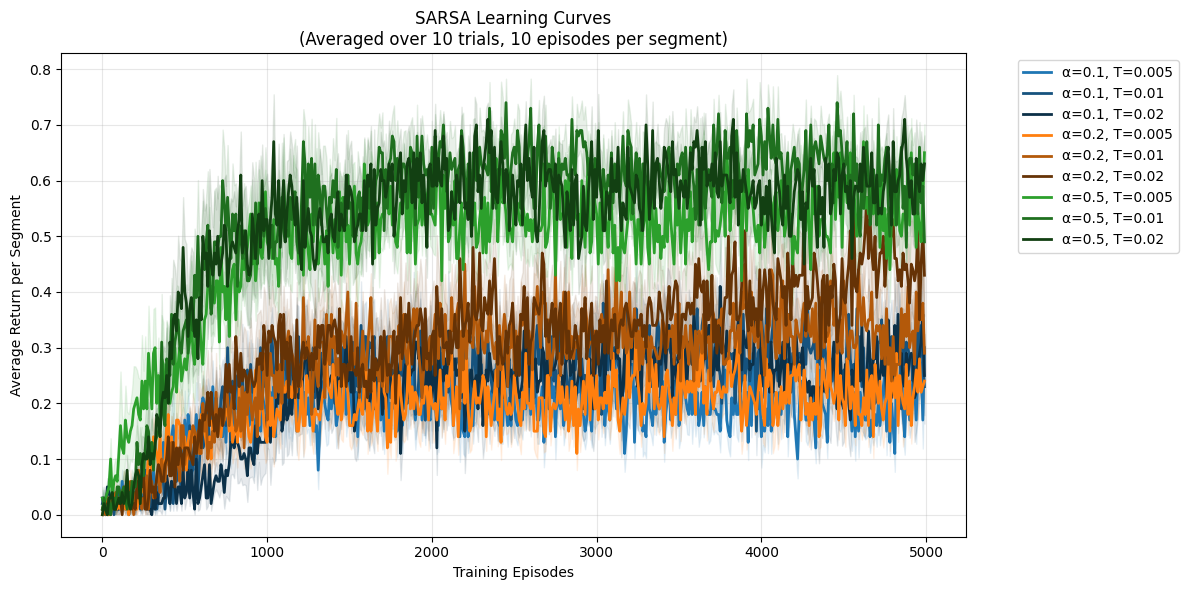

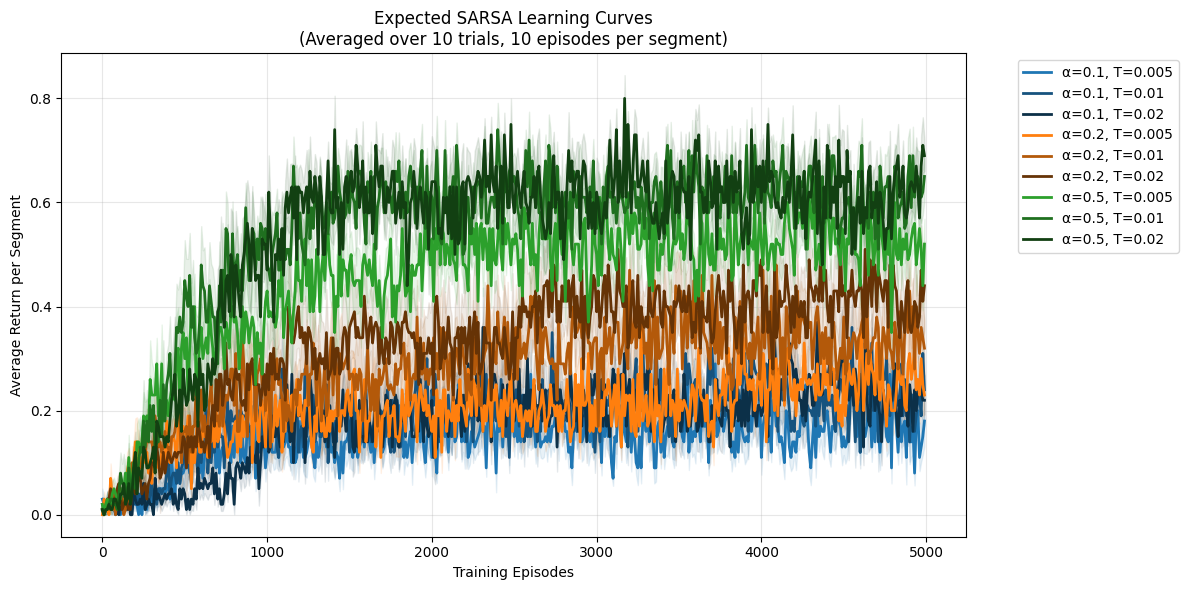

In [18]:
# Plot learning curves for both algorithms
plot_learning_curves(sarsa_results, alpha_values, temp_values, 'SARSA Learning Curves')
plot_learning_curves(expected_sarsa_results, alpha_values, temp_values, 'Expected SARSA Learning Curves')

# Graph 4


In [20]:
def plot_testing_curves(results, alpha_values, temp_values, title):
    """
    Create learning curves showing testing performance (greedy policy) over training episodes.
    
    This visualization helps us understand how the greedy policy's performance evolves during
    training. Since testing uses the greedy policy (always choosing the best action), these
    curves show how well the agent has learned the optimal policy at each stage.
    
    Args:
        results (dict): Dictionary containing training and testing results
        alpha_values (list): List of learning rates used
        temp_values (list): List of temperature values used
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Define base colors for different learning rates
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, alpha in enumerate(alpha_values):
        for j, temp in enumerate(temp_values):
            # For testing performance, we look at the test episodes after each segment
            mean_returns = np.mean(results['testing'][i, j], axis=0)
            std_error = np.std(results['testing'][i, j], axis=0) / np.sqrt(10)
            
            # Scale x-axis to match training episodes
            # Each test episode happens after 10 training episodes
            episodes = np.arange(len(mean_returns)) * 10
            
            # Create color gradient based on temperature
            base_color = np.array(plt.matplotlib.colors.to_rgb(base_colors[i]))
            shade_factor = 1 - (j * 0.3)  # Darker shades for higher temperatures
            color = base_color * shade_factor
            
            # Plot mean test performance with confidence bands
            plt.plot(episodes, mean_returns, 
                    label=f'α={alpha}, T={temp}',
                    color=color,
                    linewidth=2)
            
            # Add confidence bands to show variability
            plt.fill_between(episodes, 
                           mean_returns - std_error,
                           mean_returns + std_error,
                           color=color,
                           alpha=0.1)
    
    plt.title(f'{title}\n(Testing Performance with Greedy Policy)')
    plt.xlabel('Training Episodes')
    plt.ylabel('Test Return (Greedy Policy)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

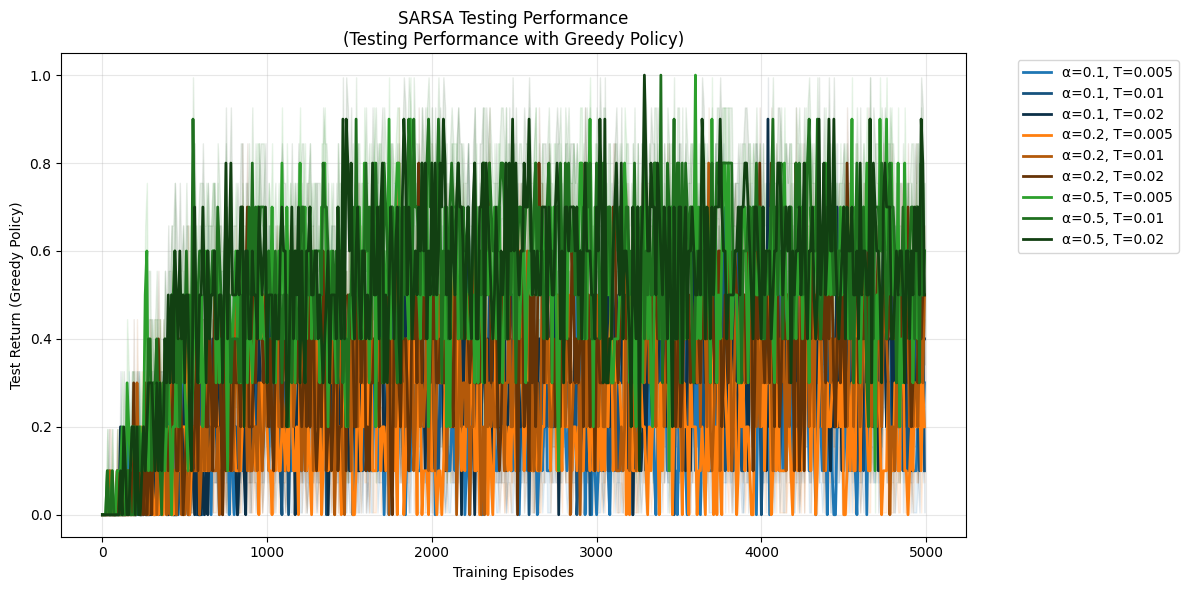

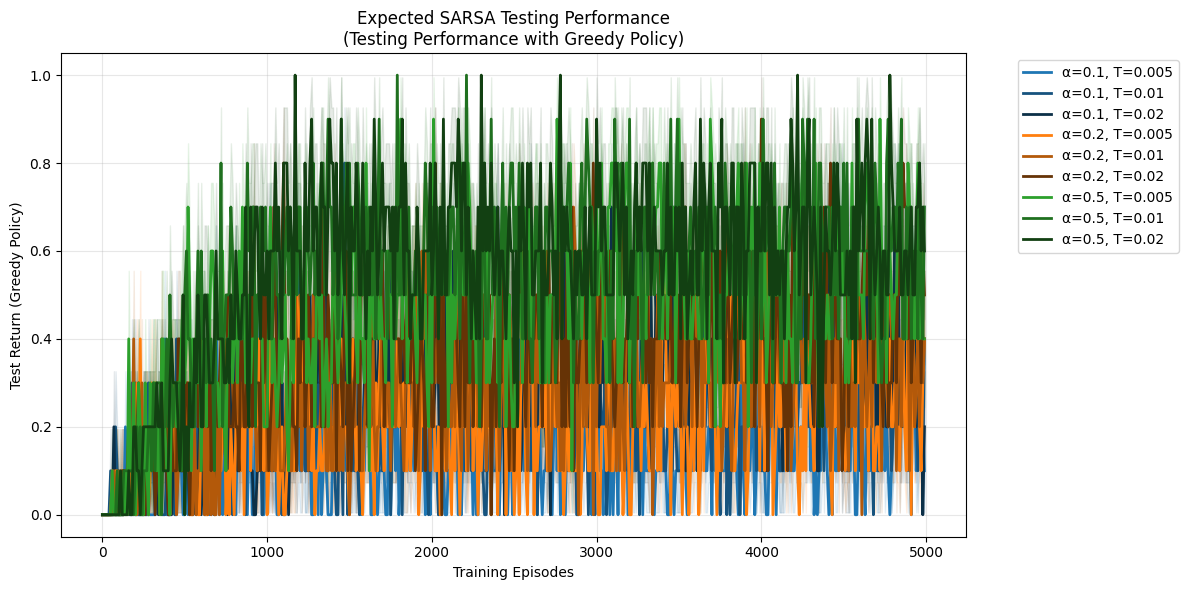

In [21]:
# Plot testing curves for both algorithms
plot_testing_curves(sarsa_results, alpha_values, temp_values, 'SARSA Testing Performance')
plot_testing_curves(expected_sarsa_results, alpha_values, temp_values, 'Expected SARSA Testing Performance')

In [22]:
def plot_smoothed_testing_curves(results, alpha_values, temp_values, title):
    """
    Create smoothed learning curves showing testing performance with proper averaging and scaling.
    
    This visualization reduces noise by:
    1. First averaging across the 10 trials for each segment
    2. Including error bands to show variation across trials
    3. Properly scaling the x-axis to show actual number of training episodes
    
    Args:
        results (dict): Dictionary containing training and testing results
        alpha_values (list): List of learning rates used
        temp_values (list): List of temperature values used
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Define base colors for different learning rates
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    # Calculate window size for moving average
    window_size = 10  # Average over 10 segments
    
    for i, alpha in enumerate(alpha_values):
        for j, temp in enumerate(temp_values):
            # First average across trials for each segment
            trial_means = np.mean(results['testing'][i, j], axis=0)
            
            # Apply moving average to smooth the curve
            smoothed_returns = np.convolve(trial_means, 
                                         np.ones(window_size)/window_size, 
                                         mode='valid')
            
            # Calculate standard error across trials
            std_error = np.std(results['testing'][i, j], axis=0) / np.sqrt(10)
            smoothed_std_error = np.convolve(std_error, 
                                           np.ones(window_size)/window_size, 
                                           mode='valid')
            
            # Scale x-axis by episodes per segment (10 episodes per segment)
            episodes = np.arange(len(smoothed_returns)) * 10
            
            # Create color gradient based on temperature
            base_color = np.array(plt.matplotlib.colors.to_rgb(base_colors[i]))
            shade_factor = 1 - (j * 0.3)  # Darker shades for higher temperatures
            color = base_color * shade_factor
            
            # Plot smoothed mean performance with confidence bands
            plt.plot(episodes, smoothed_returns, 
                    label=f'α={alpha}, T={temp}',
                    color=color,
                    linewidth=2)
            
            # Add confidence bands
            plt.fill_between(episodes, 
                           smoothed_returns - smoothed_std_error,
                           smoothed_returns + smoothed_std_error,
                           color=color,
                           alpha=0.1)
    
    plt.title(f'{title}\n(Smoothed Testing Performance, Averaged over 10 trials)')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Test Return (Greedy Policy)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

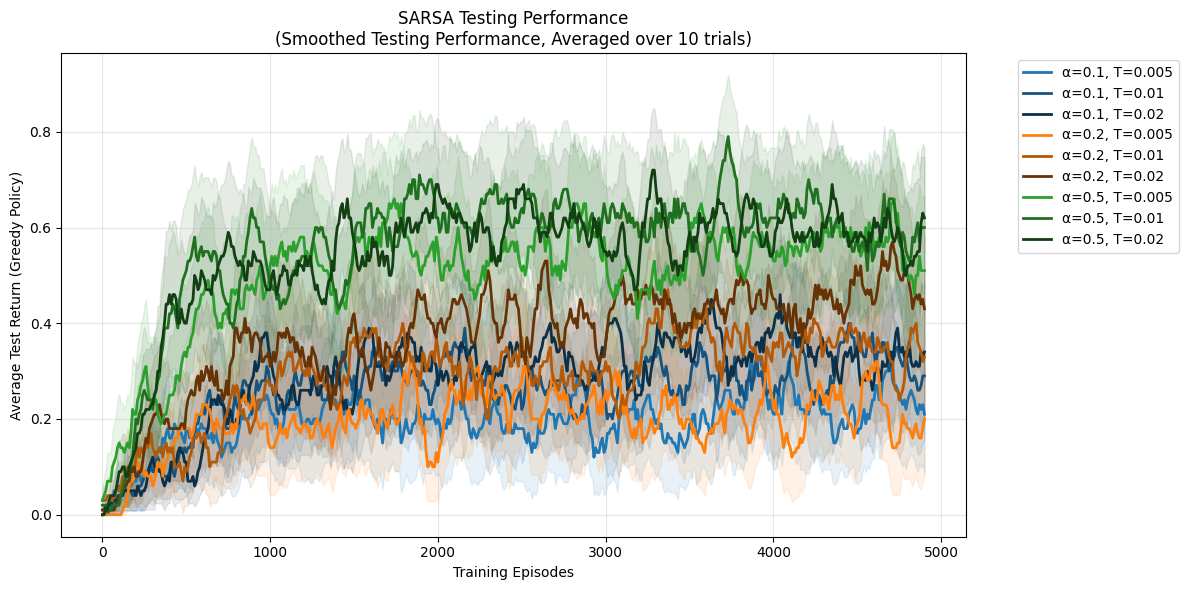

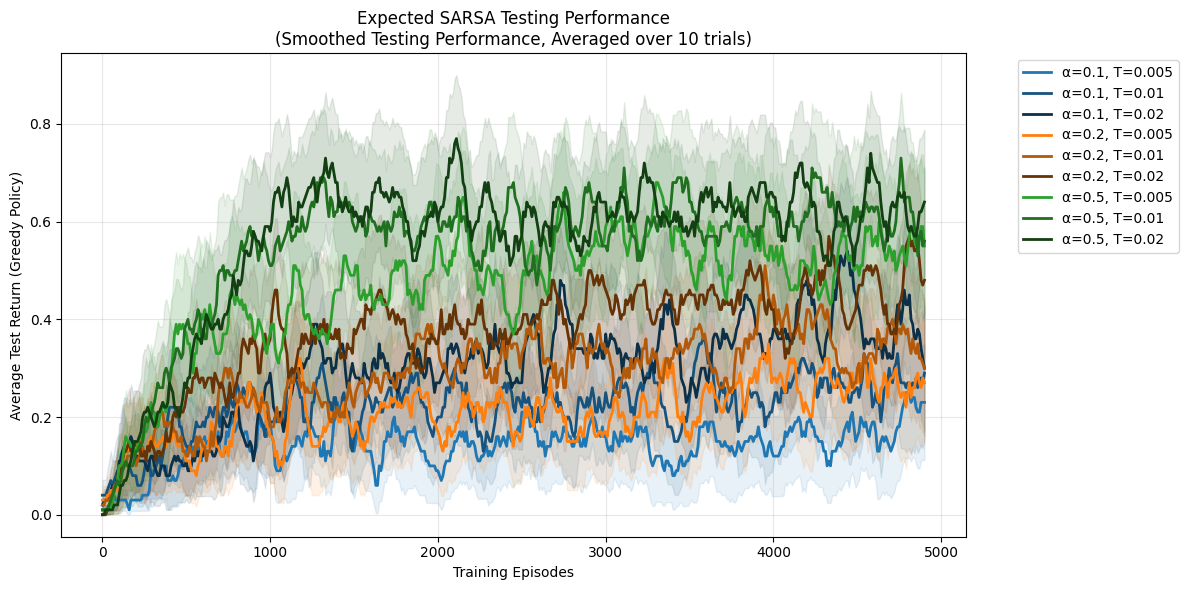

In [23]:
# Plot smoothed testing curves for both algorithms
plot_smoothed_testing_curves(sarsa_results, alpha_values, temp_values, 'SARSA Testing Performance')
plot_smoothed_testing_curves(expected_sarsa_results, alpha_values, temp_values, 'Expected SARSA Testing Performance')

# Q2


In [3]:
#This is based off of psuedo-code is sourced from lecture MDP slide 39.
import numpy as np

states = ["s1", "s2", "s3"]
terminal_state = "s3"

gamma = 0.9
theta = 1e-6  # some threshold

policy = {"s1": "a1", "s2": "a1"}

transition_rewards = {
    ("s1", "a1"): ("s2", 2),
    ("s1", "a2"): ("s3", 5),
    ("s2", "a1"): ("s3", 1),
    ("s2", "a2"): ("s1", -1),
}

#initialize V(s) = 0 for all states
V = {s: 0 for s in states}

while True:
    delta = 0
    for s in states:
        if s == terminal_state:
            continue

        v = V[s]
        a = policy[s]
        s_prime, r = transition_rewards[(s, a)]

        V[s] = r + gamma * V[s_prime] #Transition probability is always one here.

        delta = max(delta, abs(v - V[s]))

    if delta < theta:
        break

for state, value in V.items():
    print(f"V({state}) = {value:.4f}")


V(s1) = 2.9000
V(s2) = 1.0000
V(s3) = 0.0000


# Q3


In [4]:
#This is based off the pseudo-code in slid 62 of Lecture 5 MDPs.  

states = ["s1", "s2", "s3"]
terminal_state = "s3"

actions = ["a1", "a2"]

gamma = 0.9
theta = 1e-6  # some threshold

transition_rewards = {
    ("s1", "a1"): ("s2", 2),
    ("s1", "a2"): ("s3", 5),
    ("s2", "a1"): ("s3", 1),
    ("s2", "a2"): ("s1", -1),
}

V = {s: 0 for s in states}

while True:
    delta = 0
    new_V = V.copy()

    for s in states:
        if s == terminal_state:
            continue

        max_value = float("-inf")
        for a in actions:
            if (s, a) in transition_rewards:
                s_prime, r = transition_rewards[(s, a)]
                value = r + gamma * V[s_prime] #transition probs are always one.
                max_value = max(max_value, value)

        new_V[s] = max_value
        delta = max(delta, abs(V[s] - new_V[s]))

    V = new_V

    if delta < theta:
        break


optimal_policy = {}
for s in states:
    if s == terminal_state:
        continue
    best_action = None
    best_value = float("-inf")

    for a in actions:
        if (s, a) in transition_rewards:
            s_prime, r = transition_rewards[(s, a)]
            value = r + gamma * V[s_prime]
            if value > best_value:
                best_value = value
                best_action = a

    optimal_policy[s] = best_action

print("Optimal Value Function:")
for state, value in V.items():
    print(f"V({state}) = {value:.4f}")

print("\nOptimal Policy:")
for state, action in optimal_policy.items():
    print(f"π*({state}) = {action}")


Optimal Value Function:
V(s1) = 5.7895
V(s2) = 4.2105
V(s3) = 0.0000

Optimal Policy:
π*(s1) = a1
π*(s2) = a2
